In [1]:
import os
import git
from pathlib import Path

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False

In [2]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "CSVs")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
RERUN = False
np.random.seed(0)
main_df_with_classical = main_df.copy()
main_df = main_df[(main_df['dataset'] != 'standardTesting') & (main_df['transform'] != 'gabor')]
print(main_df.shape, main_df_with_classical.shape)

(1071, 47) (2160, 47)


In [3]:
main_df['dataset_type'] = main_df.apply((lambda row : row['dataset_type'] if row['dataset'] != 'standardTesting' else 'oclassical'), axis = 1)

## Aggregate Stats

In [4]:
main_df['kstest_stat_overall_best'] = np.minimum.reduce([main_df['kstest_stat_best'], main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])
temp = main_df[main_df['beat_all_priors'] == 0].copy()
n = len(main_df)

c1, c0 = main_df['beat_all_priors'].value_counts()
print("% Beats All Other Priors:", c1 / n * 100, ",", c1, "/", n)
trivial_fails, _, _, _, _ = temp['failure_category'].value_counts()
print("Given that OurPrior is Worse, % Trivial Failures:", trivial_fails / n * 100, ",", trivial_fails, "/", n)
print("Of cases where OurPrior is worse, % of Trivial Failures:", trivial_fails / c0 * 100)
temp = temp[temp['failure_category'] != 'trivial_failure']
print("Given that OurPrior is Worse, Maximum difference between OurPrior and Best:", max(np.abs(temp['kstest_stat_overall_best'] - temp['kstest_stat_best'])))

% Beats All Other Priors: 91.87675070028011 , 984 / 1071
Given that OurPrior is Worse, % Trivial Failures: 7.18954248366013 , 77 / 1071
Of cases where OurPrior is worse, % of Trivial Failures: 88.50574712643679
Given that OurPrior is Worse, Maximum difference between OurPrior and Best: 0.0035451361585638


In [5]:
main_df['failure_category'].sort_values().value_counts()

failure_category
practically_pass       610
trivial_failure        228
actually_pass          167
borderline              45
interesting_failure     21
Name: count, dtype: int64

In [6]:
practical, trivial, actual, border, interesting = main_df['failure_category'].sort_values().value_counts()
print("Actually Passing:", (actual) / n)
print("Practically Passing:", (practical) / n)
print("Passing Overall:", (practical + actual) / n)
print("Passing Overall (borderline):", (practical + actual + border) / n)


Actually Passing: 0.15592903828197946
Practically Passing: 0.5695611577964519
Passing Overall: 0.7254901960784313
Passing Overall (borderline): 0.7675070028011205


In [7]:
main_df = main_df[main_df['total_samples'].iloc[:, 0] > 100]
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r']
main_df = main_df#[(main_df['dataset'] != 'standardTesting')]

In [8]:
name_mapping = {'syntheticMRI3Dfull': 'syntheticMRI3D',
                'syntheticMRI2Daxial': 'syntheticMRI2D (axial)',
                'syntheticMRI2Dsagittal': 'syntheticMRI2D (sagittal)',
                'syntheticMRI2Dcoronal': 'syntheticMRI2D (coronal)',
                'spaceNetfull': 'spaceNet',
                'cocoindoor': 'coco (indoor)',
                'cocooutdoor': 'coco (outdoor)',
                'pastisfull': 'pastis',
                'segmentAnythingfull': 'segmentAnything',
                'agriVisionfull': 'agriVision',
                'standardTestingfull': 'standardTesting'}

main_df['dataset'] = (main_df['dataset'] + main_df['subset']).replace(name_mapping)

In [9]:
main_df['hull_eta_lower'] = main_df['hull_beta_lower']
main_df["n_pval_0.05"]

0         56952.0
1         74038.0
2        106312.0
3        139218.0
4        212625.0
          ...    
2155      42786.0
2156    1502428.0
2157      90020.0
2158     222910.0
2159     263374.0
Name: n_pval_0.05, Length: 1055, dtype: float64

In [10]:
granularity1 = ['transform', 'dataset_type', 'dataset']
final_cols =  ['median_total_samples', 'kstest_stat_best', 'statistically_pass', 'combined_pass', 'intersect_roi']  #, 'uses_practical_threshold', 'intersect_roi', 'hull_r_lower_ci95', 'hull_r_upper_ci95', 'hull_beta_lower_ci95', 'hull_beta_upper_ci95']
temp = main_df.copy()# & (main_df['transform'] != 'learned')]
temp['orientation'] = temp.apply(
    lambda row: 'fourier' if row['transform'] == 'fourier' 
    else ('learned' if row['transform'] == 'learned' else row['orientation']),
    axis=1
)
temp['practically_pass'] = (temp['failure_category'] == 'practically_pass')
temp['statistically_pass'] = (temp['failure_category'] == 'actually_pass')
temp['borderline'] = (temp['failure_category'] == 'borderline')
temp["interesting_failure"] = (temp['failure_category'] == 'interesting_failure')
temp["trivial_failure"] = (temp['failure_category'] == 'trivial_failure')

summary_df = (temp.groupby(granularity1)[['statistically_pass','practically_pass', "borderline", 'interesting_failure', 'trivial_failure', 'intersect_roi']].mean() * 100).round(1)#.sort_values('dataset')
summary_df["kstest_stat_best"] = temp.groupby(granularity1)['kstest_stat_best'].median(numeric_only=True)
# summary_df["kstest_stat_best_std"] = temp.groupby(granularity1)['kstest_stat_best'].std(numeric_only=True)
# summary_df["kstest_stat_best"] = (summary_df["kstest_stat_best_median"].round(4).astype(str) + " (" + (2*summary_df["kstest_stat_best_std"]).round(4).astype(str) + ")")
summary_df["median_total_samples"] = temp.groupby(granularity1)['total_samples'].median().astype(float).iloc[:,0].apply(lambda x : np.format_float_scientific(x, exp_digits=1, precision=1))
summary_df["combined_pass"] = summary_df['statistically_pass'] + summary_df['practically_pass']

for col in ['hull_r_lower', 'hull_r_upper', 'hull_beta_lower', 'hull_beta_upper']:
    summary_df[f'{col}_ci95'] = temp.groupby(granularity1)[col].apply(lambda x:  [np.round(x, 2) for x in np.percentile(x, [2.5, 97.5])])
summary_df = summary_df[final_cols].round(3) #.reset_index()#.drop('dataset', axis=1)
summary_df

median_total_samples  \
transform dataset_type   dataset                                          
fourier   remote sensing agriVision                              2.6e+6   
                         pastis                                  2.6e+5   
                         spaceNet                                1.8e+6   
learned   natural        coco (indoor)                            2.e+8   
                         coco (outdoor)                           2.e+8   
                         segmentAnything                         7.9e+8   
          remote sensing agriVision                              7.9e+8   
                         pastis                                  4.9e+7   
                         spaceNet                                4.8e+8   
wavelet   medical        syntheticMRI2D (axial)                  4.2e+6   
                         syntheticMRI2D (coronal)                3.7e+6   
                         syntheticMRI2D (sagittal)               2.4e+6   
                         syntheticMRI3D                          1.6e+6   
          natural        coco (indoor)                           2.6e+5   
                         coco (outdoor)                          3.9e+5   
                         segmentAnything                         1.8e+6   
          remote sensing agriVision                              1.7e+6   
                         pastis                                  1.5e+5   
                         spaceNet                                1.6e+6   

                                                    kstest_stat_best  \
transform dataset_type   dataset                                       
fourier   remote sensing agriVision                            0.005   
                         pastis                                0.002   
                         spaceNet                              0.005   
learned   natural        coco (indoor)                         0.009   
                         coco (outdoor)                        0.010   
                         segmentAnything                       0.005   
          remote sensing agriVision                            0.005   
                         pastis                                0.004   
                         spaceNet                              0.013   
wavelet   medical        syntheticMRI2D (axial)                0.007   
                         syntheticMRI2D (coronal)              0.004   
                         syntheticMRI2D (sagittal)             0.005   
                         syntheticMRI3D                        0.005   
          natural        coco (indoor)                         0.013   
                         coco (outdoor)                        0.011   
                         segmentAnything                       0.004   
          remote sensing agriVision                            0.005   
                         pastis                                0.004   
                         spaceNet                              0.012   

                                                    statistically_pass  \
transform dataset_type   dataset                                         
fourier   remote sensing agriVision                                2.3   
                         pastis                                   90.9   
                         spaceNet                                  0.0   
learned   natural        coco (indoor)                             0.0   
                         coco (outdoor)                            0.0   
                         segmentAnything                           0.0   
          remote sensing agriVision                                0.0   
                         pastis                                    0.0   
                         spaceNet                                  0.0   
wavelet   medical        syntheticMRI2D (axial)                    0.0   
                         syntheticMRI2D (coronal)                  9.5   


In [11]:
granularity2 = ['transform', 'dataset_type']
temp = main_df.copy()# & (main_df['transform'] != 'learned')]
temp['orientation'] = temp.apply(
    lambda row: 'fourier' if row['transform'] == 'fourier' 
    else ('learned' if row['transform'] == 'learned' else row['orientation']),
    axis=1
)
temp['practically_pass'] = (temp['failure_category'] == 'practically_pass')
temp['statistically_pass'] = (temp['failure_category'] == 'actually_pass')
temp['borderline'] = (temp['failure_category'] == 'borderline')
temp["interesting_failure"] = (temp['failure_category'] == 'interesting_failure')
temp["trivial_failure"] = (temp['failure_category'] == 'trivial_failure')
summary_df2 = (temp.groupby(granularity2)[['statistically_pass','practically_pass', "borderline", 'interesting_failure', 'trivial_failure', 'intersect_roi']].mean() * 100).round(1)#.sort_values('dataset')
summary_df2["kstest_stat_best"] = temp.groupby(granularity2)['kstest_stat_best'].median(numeric_only=True)
summary_df2["kstest_stat_best_std"] = temp.groupby(granularity2)['kstest_stat_best'].std(numeric_only=True)
summary_df2["median_total_samples"] = temp.groupby(granularity2)['total_samples'].median().astype(float).iloc[:,0].apply(lambda x : np.format_float_scientific(x, 1))
summary_df2["combined_pass"] = summary_df2['statistically_pass'] + summary_df2['practically_pass']
for col in ['hull_r_lower', 'hull_r_upper', 'hull_beta_lower', 'hull_beta_upper']:
    summary_df2[f'{col}_ci95'] = temp.groupby(granularity2)[col].apply(lambda x:  [np.round(x, 1) for x in np.percentile(x, [2.5, 97.5])])


summary_df2 = summary_df2[final_cols].round(3) #.reset_index()#.drop('dataset', axis=1)
summary_df2 = summary_df2.assign(dataset='z_aggregate').reset_index().set_index(granularity1)
summary_df_final = pd.concat([summary_df, summary_df2]).reset_index()

summary_df_final['transform'] = pd.Categorical(summary_df_final['transform'], categories=['fourier', 'wavelet', 'gabor', 'learned'], ordered=True)
summary_df_final = summary_df_final.sort_values(['transform', 'dataset_type', 'dataset'])
summary_df_final.to_csv(os.path.join(plots_path, 'results_table.csv'))

In [12]:
summary_df_final

,transform,dataset_type,dataset,median_total_samples,kstest_stat_best,statistically_pass,combined_pass,intersect_roi
0,fourier,remote sensing,agriVision,2.6e+6,0.005,2.3,95.5,68.2
1,fourier,remote sensing,pastis,2.6e+5,0.002,90.9,100.0,100.0
2,fourier,remote sensing,spaceNet,1.8e+6,0.005,0.0,100.0,46.9
19,fourier,remote sensing,z_aggregate,5.5e+05,0.003,34.2,98.4,74.2
9,wavelet,medical,syntheticMRI2D (axial),4.2e+6,0.007,0.0,76.2,33.3
10,wavelet,medical,syntheticMRI2D (coronal),3.7e+6,0.004,9.5,80.9,57.1
11,wavelet,medical,syntheticMRI2D (sagittal),2.4e+6,0.005,0.0,81.0,76.2
12,wavelet,medical,syntheticMRI3D,1.6e+6,0.005,7.1,69.0,64.3
22,wavelet,medical,z_aggregate,2.9e+06,0.005,4.8,75.3,59.0
13,wavelet,natural,coco (indoor),2.6e+5,0.013,25.0,50.0,18.8


In [40]:
print("Median Total Samples Overall:", temp[['total_samples']].median().iloc[0])
print("Median KS statistic:", temp[['kstest_stat_best']].median().iloc[0])
temp[['statistically_pass', 'practically_pass', 'intersect_roi']].mean()

Median Total Samples Overall: 8502500.0
Median KS statistic: 0.0064770613601176


statistically_pass    0.158294
practically_pass      0.578199
intersect_roi         0.408531
dtype: float64

In [13]:
temp[['statistically_pass', 'practically_pass', 'intersect_roi', 'hull_area', 'total_samples']].mean(), main_df[['total_samples']].median()


(statistically_pass    1.582938e-01
 practically_pass      5.781991e-01
 intersect_roi         4.085308e-01
 hull_area             1.325534e+01
 total_samples         1.630017e+08
 total_samples         1.630017e+08
 dtype: float64,
 total_samples    8502500.0
 total_samples    8502500.0
 dtype: float64)

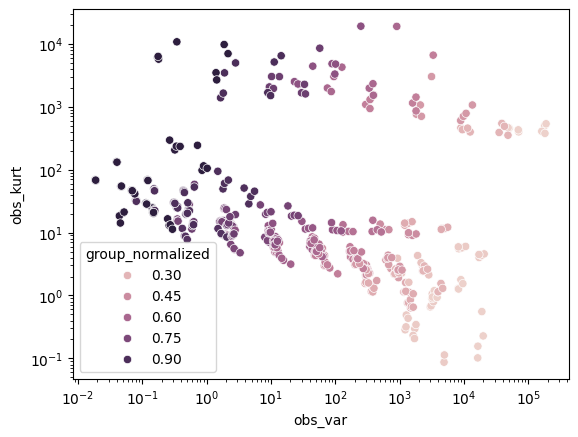

In [14]:
main_df['group_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['group'].transform(lambda x: x / x.max())
main_df['var_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['obs_var'].transform(lambda x: x / x.max())
main_df['kurt_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['obs_kurt'].transform(lambda x: x / x.max())
sns.scatterplot(data=main_df[main_df['transform'] != 'learned'], x='obs_var', y='obs_kurt', hue='group_normalized')
plt.xscale('log')
plt.yscale('log')


In [15]:
[stats.kstwo(n=10**i).isf(0.05) for i in range(3, 10)]

[0.042776500461245,
 0.013564202793681023,
 0.004293014618329405,
 0.0013579318555276864,
 0.0004294518283725128,
 0.00013580819714844155,
 4.294668320280901e-05]

In [16]:
main_df['n_pval_0.05']

0         56952.0
1         74038.0
2        106312.0
3        139218.0
4        212625.0
          ...    
2155      42786.0
2156    1502428.0
2157      90020.0
2158     222910.0
2159     263374.0
Name: n_pval_0.05, Length: 1055, dtype: float64

<Axes: >

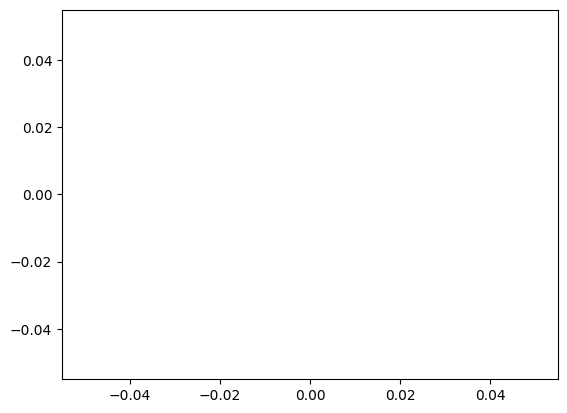

In [17]:
sns.histplot()